In [1]:
%matplotlib
%matplotlib inline
import numpy
import matplotlib.pyplot as plt
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import math, gillespy2
from gillespy2.basic_tau_hybrid_solver import BasicTauHybridSolver

Using matplotlib backend: Qt5Agg


The performance of this package can be significantly increased if you install Cython.


In [86]:
class DayModel(gillespy2.Model):
    def __init__(self, parameter_values=None, init_v=0):
        # initialize
        gillespy2.Model.__init__(self, name="Macrophage")
        
        # species
        S_ = gillespy2.Species(name='S_', initial_value=1e6)
        M_ = gillespy2.Species(name='M_', initial_value=1e6)
        H_ = gillespy2.Species(name='H_', initial_value=0)
        E_ = gillespy2.Species(name='E_', initial_value=2e9)
        Be_ = gillespy2.Species(name='Be_', initial_value=0)
        N_ = gillespy2.Species(name='N_', initial_value=0)
        Ta_ = gillespy2.Species(name='Ta_', initial_value=1)
        
        self.add_species([S_,M_,H_,E_,Be_,N_,Ta_])
        
        # parameters
        ns = gillespy2.Parameter(name='ns', expression=2) # avg = 3.38
        nb = gillespy2.Parameter(name='Nb', expression=5)
        
        k1 = gillespy2.Parameter(name='k1', expression=1e-5)
        k2 = gillespy2.Parameter(name='k2', expression=3.1e-10) #
        k3 = gillespy2.Parameter(name='k3', expression=0.05)
        k4 = gillespy2.Parameter(name='k4', expression=2)
        k5 = gillespy2.Parameter(name='k5', expression=0.8)
        k6 = gillespy2.Parameter(name='k6', expression=5e-10)
        k8 = gillespy2.Parameter(name='k8', expression=6e-10)
        k9 = gillespy2.Parameter(name='k9', expression=5e-10)
        k10 = gillespy2.Parameter(name='k10', expression=1e-10)
        
        Sa = gillespy2.Parameter(name='Sa_', expression=0)
        Se = gillespy2.Parameter(name='Se_', expression=0)
        
        MuA = gillespy2.Parameter(name='MuA', expression=0.05)
        MuE = gillespy2.Parameter(name='MuE', expression=0.05)
        MuN = gillespy2.Parameter(name='MuN', expression=0.06)
        MuTa = gillespy2.Parameter(name='MuTa', expression=2)
        
        N0 = gillespy2.Parameter(name='N0', expression=5500)
        
        BeMAX = gillespy2.Parameter(name='BeMAX', expression=5e11)
        
        CT1 = gillespy2.Parameter(name='CT1', expression=1)
        CT2 = gillespy2.Parameter(name='CT2', expression=1)
        CT3 = gillespy2.Parameter(name='CT3', expression=1)
        CTB = gillespy2.Parameter(name='CTB', expression=1000)
        
        self.add_parameter([ns,nb,k1,k2,k3,k4,k5,k6,k8,k9,k10,Sa,Se,MuA,MuE,MuN,MuTa,N0,BeMAX,CT1,CT2,CT3,CTB])
        
        # reactions
        r1 = gillespy2.Reaction(name='r1', reactants={S_:int(ns.expression),M_:1}, products={H_:1},
                               propensity_function="(k2*S_*M_)/ns")
        
        r2 = gillespy2.Reaction(name='r2', reactants={}, products = {M_:1},
                                rate=Sa)
        
        r3 = gillespy2.Reaction(name='r3', reactants={M_:1}, products = {},
                                rate=MuA)
        
        r4 = gillespy2.Reaction(name='r4', reactants={H_:1}, products = {Be_:int(nb.expression)},
                                rate=k3)
        
        r5 = gillespy2.Reaction(name='r5', reactants={Be_:1, E_:1}, products={Be_:1},
                                rate=k1)
        
        r6 = gillespy2.Reaction(name='r5', reactants={E_:1}, products={},
                                rate=MuE)
        
        r7 = gillespy2.Reaction(name='r5', reactants={Be_:1, E_:1}, products={E_:1},
                                rate=k6)
        
        r8 = gillespy2.Reaction(name='r7', reactants={Be_:1}, products={Be_:1},
                                propensity_function="k5*(1-(Be_/BeMAX))")
        
        r9 = gillespy2.Reaction(name='r9', reactants={Be_:1}, products={},
                                propensity_function="(k5*N_*Be_)/(1+(Ta_/CT1))")
        
        r10 = gillespy2.Reaction(name='r10', reactants={N_:1,Be_:1}, products={N_:1},
                                propensity_function="(k9*Be_*E_*N0)/(1+(Ta_/CT2))")
        
        r11 = gillespy2.Reaction(name='r11', reactants={N_:1}, products={N_:1},
                                propensity_function="(k10*N_*N0)/(1+(Ta_/CT3))")
        
        r12 = gillespy2.Reaction(name='r12', reactants={N_:1}, products={},
                                rate=MuN)
        
        r13 = gillespy2.Reaction(name='r13', reactants={Be_:1}, products={Ta_:1},
                                propensity_function="k4*(Be_/(CTB+Be_))")
        
        r14 = gillespy2.Reaction(name='r14', reactants={Ta_:1}, products={},
                                rate=MuTa)
        
        self.add_reaction([r1,r2,r3,r4,r5,r6,r7,r8,r9,r10,r11,r12,r13,r14])
        t = numpy.linspace(0,3600,361)
        self.timespan(t)
        # print(t)

In [87]:
model = DayModel()

In [88]:
%time results = model.run(solver=BasicTauHybridSolver())

Wall time: 7.8 s


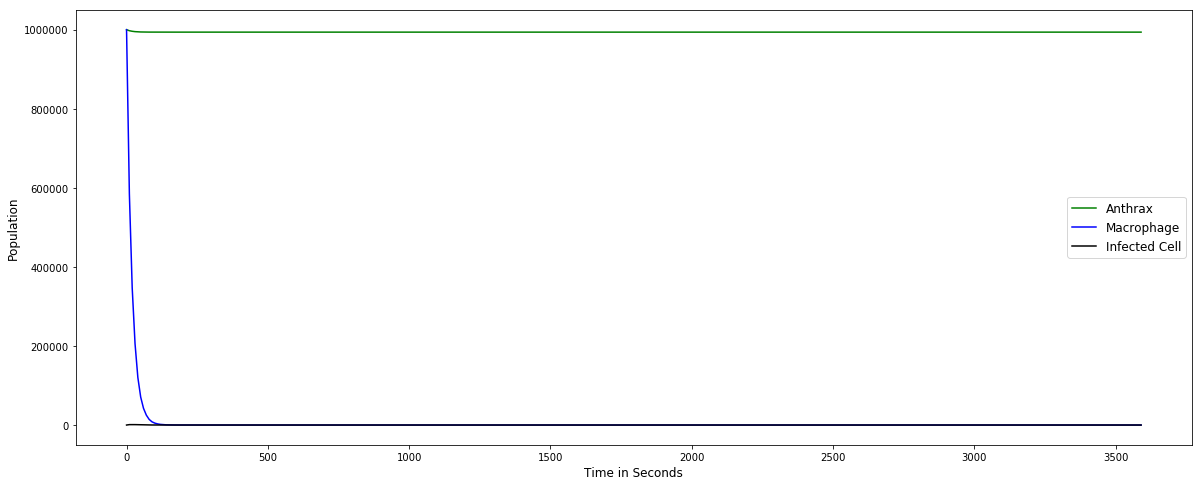

In [89]:
fig = plt.figure(figsize=(20,8))
plt.plot(results['time'], results['S_'], 'g-', label='Anthrax')
plt.plot(results['time'], results['M_'], 'b-', label='Macrophage')
plt.plot(results['time'], results['H_'], 'k-', label='Infected Cell')
plt.xlabel("Time in Seconds", fontsize=12)
plt.ylabel("Population", fontsize=12)
plt.legend(loc='best', fontsize=12)
#print(results['S_'][-1]/(results['S_'][0]/int(model.listOfParameters['ns'].expression)))





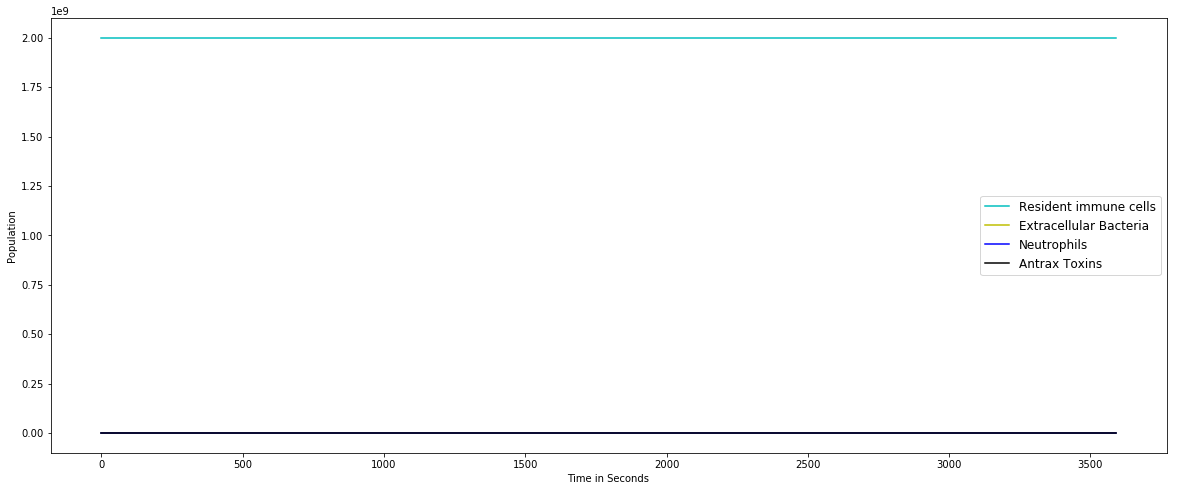

In [90]:
fig = plt.figure(figsize=(20,8))
plt.plot(results['time'], results['E_'], 'c-', label='Resident immune cells')
plt.plot(results['time'], results['Be_'], 'y-', label='Extracellular Bacteria')
plt.plot(results['time'], results['N_'], 'b-', label='Neutrophils')
plt.plot(results['time'], results['Ta_'], 'k-', label='Antrax Toxins')
plt.xlabel("Time in Seconds")
plt.ylabel("Population")
plt.legend(loc='best', fontsize=12)